## Workspace setup
Installing Jupyter Lab using ``pip3 install jupyterlab``.
Vim keybinding for JupyterLab is from [here](https://github.com/jwkvam/jupyterlab-vim). There are requirements for this extansion. ``sudo apt-get install jodejs npm``. Install the extension with ``jupyter labextension install jupyterlab_vim``.

Use ``;`` at the end of the plotting line to supress text

In [25]:
import pandas as pd
def load_data(datasetCsv='housing.csv'):
    return pd.read_csv('datasets/'+datasetCsv)

In [26]:
housing = load_data()

In [27]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


###### How many __different__ types of values are possible? 
Answer is ``value_counts()``.

In [28]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [29]:
len(housing)

20640

##### Plotting

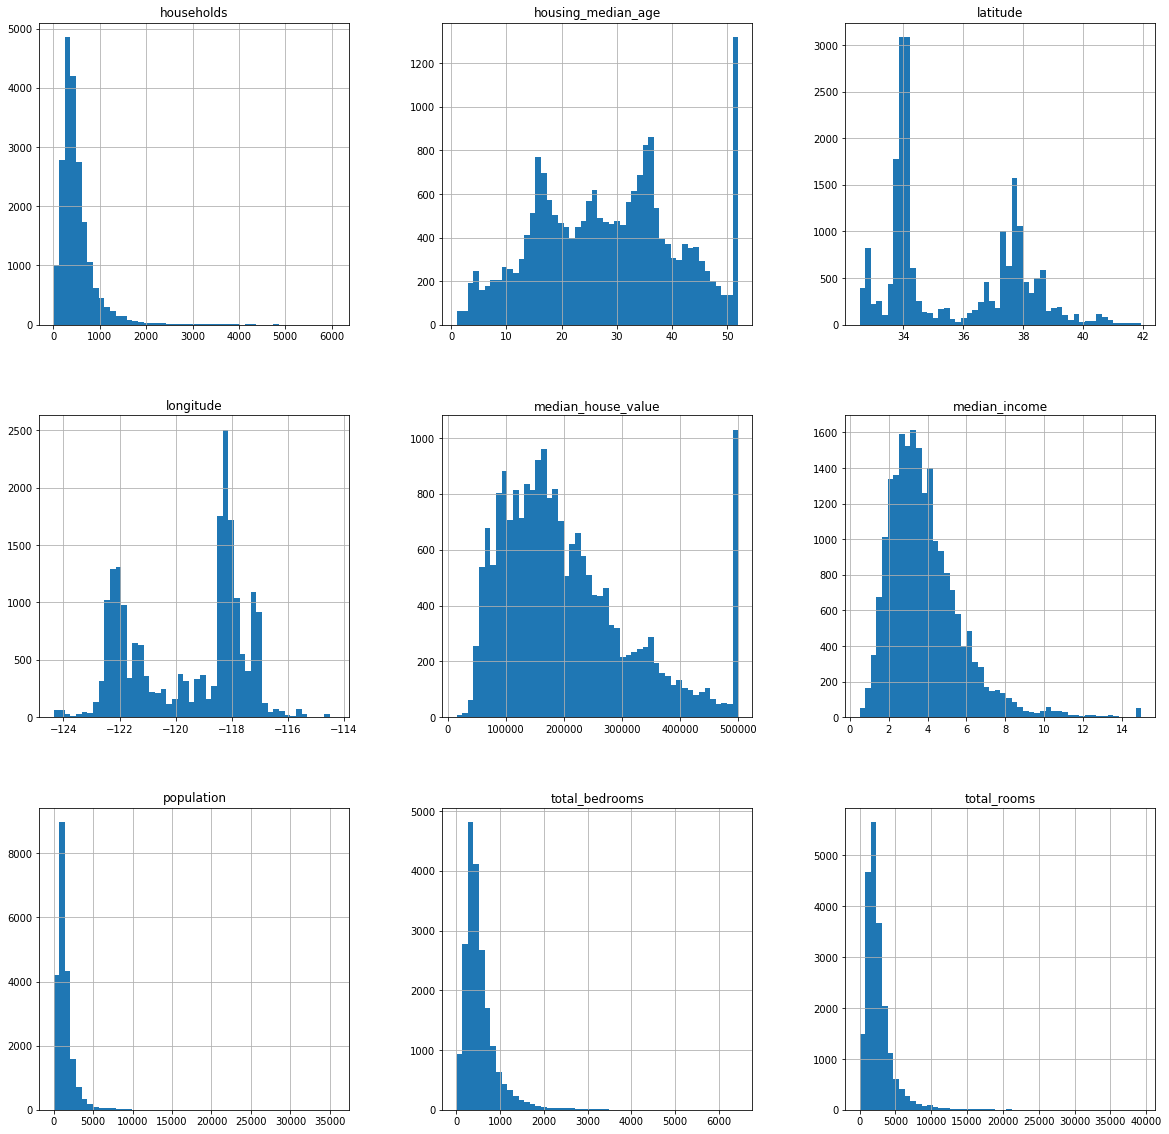

In [30]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize = (20, 20))
plt.show()

Apprantly, tail-heavy distributions are harder for machine learning algorithms to detect patterns. (Citations needed) So, there are some attempts to apply some transformations to make them more bell-shaped.

## Splitting data for train and test
To avoid *data snooping bias*, need to set aside the test dataset at this point.

In [6]:
import numpy as np
def split_train_test(data, test_ratio):
    # create randomly permute 0:len(data)
    shuffled_indices = np.random.permutation(len(data))
    # instead of floor, using int to get an integer
    test_set_size = int( len(data)* test_ratio )
    # test_indices are the first few; [:b] = [0:b-1]
    test_indices = shuffled_indices[:test_set_size]
    # train data are the remaining last ones
    train_indices = shuffled_indices[test_set_size:]
    print(len(train_indices), "train + ", len(test_indices), "test")
    return data.iloc[train_indices], data.iloc[test_indices]
    

In [7]:
# usually 20% of the original data is saved for testing
housing_train, housing_test = split_train_test(housing, 0.2)


16512 train +  4128 test


#### Caution: Note about Matlab-style index
Python indices start with 0 but the ending index is one less than what it is usually
##### ``[a:b]`` = [a, ... , b-1]
Also, ``[:5] = [0:5]`` and ``[-5:] =`` last five elements.

In [8]:
a = housing.values[0:4]
print(a)

[[-122.23 37.88 41.0 880.0 129.0 322.0 126.0 8.3252 452600.0 'NEAR BAY']
 [-122.22 37.86 21.0 7099.0 1106.0 2401.0 1138.0 8.3014 358500.0
  'NEAR BAY']
 [-122.24 37.85 52.0 1467.0 190.0 496.0 177.0 7.2574 352100.0 'NEAR BAY']
 [-122.25 37.85 52.0 1274.0 235.0 558.0 219.0 5.6431 341300.0 'NEAR BAY']]


##### Subest of the data
* While selecting a few columns, don't forget the double brackets
* ``iloc`` (integer location) with one-dimensional argument referes to the row numbers. e.g. ``data.iloc[2]``= 3rd row
* While selecting columns using ``iloc``, don't forget to use two-dimensional arguments
* Ending index while using ``:`` is actually one less

In [9]:
housing[['households', 'median_income']]
# 7th and 8th column
housing.iloc[:,[6,7]].head()

,households,median_income
0,126.0,8.3252
1,1138.0,8.3014
2,177.0,7.2574
3,219.0,5.6431
4,259.0,3.8462


The purpose is to make the splitting process consistent after the main dataset has been modified. I.e., after adding new data, the test set has to be a strict superset of the previous test data.

In [10]:
# some strange hash function
import hashlib
def test_set_check(identifier, test_ratio, hash):
    hashval = hash(np.int64(identifier))
    return hashval.digest()[-1] < 256 *test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index() # adds index col
train_set, test_set  = split_train_test_by_id(housing_with_id, 0.2, "index")

In [12]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set  = split_train_test_by_id(housing_with_id, 0.2, "id")

Note: It seems that the last byte of the hash function has a lot of non-uniqueness. So I'm not if that is usable.

### Splitting data done with sklearn's train_test_split
They allow you to random seed using ``random_state``

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=23)

Note: Instead of purely random sampling, the splitting should be done while making sure samples from all groups (*strata*) are done uniformly to avoid bias in sampling.

## Creating fake categories within an attribute
To ensure uniform sampling from all representative categories of an important feature (e.g. ``median_income`` here), we create categories of median_income

In [14]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
print(housing[["income_cat", "median_income"]].head())

   income_cat  median_income
0         5.0         8.3252
1         5.0         8.3014
2         5.0         7.2574
3         4.0         5.6431
4         3.0         3.8462


### Notes on ``where()``
``np.where()`` is quite different from ``df.where()`` where ``df`` is a Numpy dataframe.
First, ``np.where(condition)`` returns the *indices* of a dataframe satisfying a condition. But ``df.where(condition_to_keep_intact, value_to_set_if_condition_is_false, inplace=True/False)``
See [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.where.html) for further explantions. ``df1.where()`` works only for dataframes.

In [15]:
this = np.arange(25).reshape(5,5) # arange(10) (not arrange) is Matlab 1:10, reshape for matrix dimension
np.where((5< this) & (this < 10)) # prints the row and column indices of matching entries

(array([1, 1, 1, 1]), array([1, 2, 3, 4]))

In [16]:
this = pd.Series(range(5))
print(this)
this.where(this > 2, 7)

0    0
1    1
2    2
3    3
4    4
dtype: int64


0    7
1    7
2    7
3    3
4    4
dtype: int64

### Sklearn's Stratified Shuffle Split

Not sure why there is a ``for`` loop needed, but let's accept it witout questions

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
# Setting up the splitter
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=43)

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

First, we look at the proportions of different income_categories. Next, we check if the stratified train data has similar distribution. Same goes for the test data, if everything goes well.

In [18]:
housing["income_cat"].value_counts()/ len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [19]:
strat_train_set["income_cat"].value_counts()/ len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [20]:
strat_test_set["income_cat"].value_counts()/ len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

So, we have the done the stratified sampling right.
Now, we remove the attribute ``income_cat`` from all the data. The argument ``axis=1`` implies that it is a column name.

In [21]:
# runs only once, since the column is deleted after that
strat_train_set.drop(["income_cat"], axis=1, inplace=True)
strat_test_set.drop(["income_cat"], axis=1, inplace=True)

Copy the trainting dataset without touching it.

In [22]:
housing = strat_train_set.copy()

## Visualize geographical data
Scatterplot is suitable for geographical data. Since there are overlaps of the circles, low values of alpha is desirable for visibility.

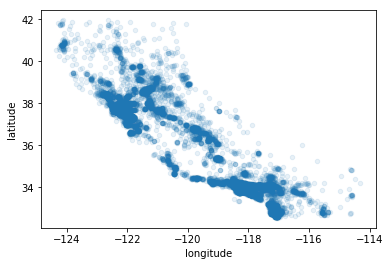

In [23]:
housing.plot(kind="scatter", x="longitude", y = "latitude", alpha=0.1)

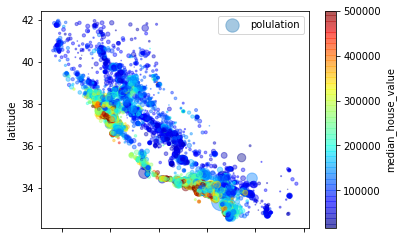

In [24]:
housing.plot(kind="scatter", x="longitude", y = "latitude", 
             alpha=0.4, s= housing['population']/100, label= 'polulation',
             c = "median_house_value", cmap=plt.get_cmap("jet"), colorbar = True)
plt.legend()


The argument `s` is the radius of the circles, `c` is the color to be used. The colormap `jet` is not bad. `colorbar` produces the bar on the right. `legend` is necessary for the the axis names. 

### Correlation coefficient between every pair of attributes
The correlation coefficient or *Pearson's r* between two vectors are defined as
$$
Corr_{X,Y} = \frac{\sum\limits_{i=1}^{n} (x_i - \bar{x}) (y_i - \bar{y})} {\sqrt{x_i - \bar{x}} \sqrt{y_i - \bar{y}}} \in [-1, 1]
$$
When the absolute value of the quantity is near 1, there is a strong **linear** correlation. This quantity cannot compute the negative correlation at all. Slope of the data does not affect the value of the linear correlation.

In [29]:
corr_mat = housing.corr()
# printing the column corresponding to median_house_value
corr_mat["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690551
total_rooms           0.135290
housing_median_age    0.107099
households            0.066341
total_bedrooms        0.050002
population           -0.024069
longitude            -0.040318
latitude             -0.148121
Name: median_house_value, dtype: float64

### Plotting to observe correlation
The ``scatter_matix`` package prints such plots

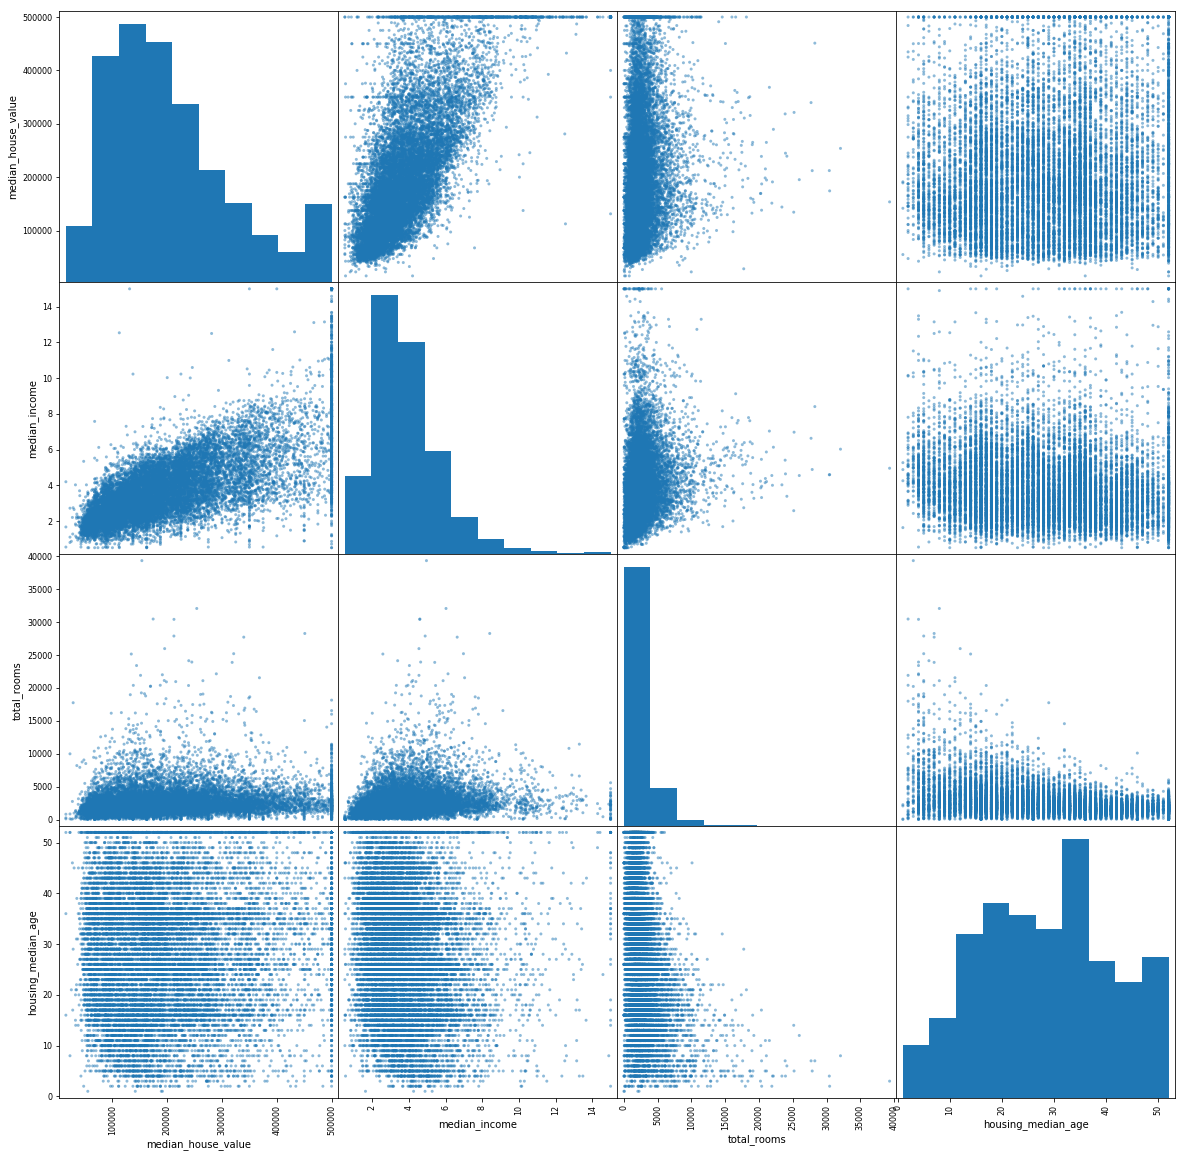

In [30]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(20,20));

The diagonal plots are the correlations with itself, so have no use. We look at the first column or the first row, since we want to find the correration of other attribues with  ``median_house_value`` attribute. There are linear relation with the second and third attribues visible from the picture. (Recall, for linear correlation, the slope is irrerelvant). The book says, ``median_income`` (second attribute) is the most interesting one.

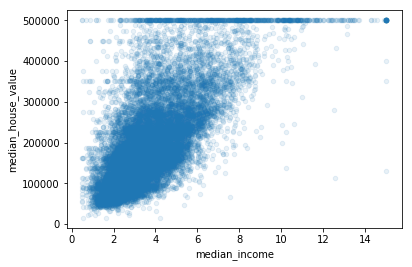

In [31]:
housing.plot(kind='scatter', x= 'median_income', y= 'median_house_value', alpha=0.1);

There is a concentration of data points at the top due to data caps applied to data during collection (e.g.setting all values aboue 50,0000 to 50,0000).

Very subtle straight lines at 480,000 and 350,000 etc that seems artifitial. We need to remove the districts that caused this, otherwise, they will pollute the data.

### Creating new attributes in the hope of better correlation
Upon consideration, it seems that the following quantities may be useful in predicting the value of the houses. 

In [32]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [33]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690551
rooms_per_household         0.156074
total_rooms                 0.135290
housing_median_age          0.107099
households                  0.066341
total_bedrooms              0.050002
population_per_household   -0.022871
population                 -0.024069
longitude                  -0.040318
latitude                   -0.148121
bedrooms_per_room          -0.257121
Name: median_house_value, dtype: float64

Indeed, the attribute ``bedrooms_per_room`` shows a negative correlation with the house value. 

## Setting up the data for feeding
The author now set up the X and y values of the training set.

In [34]:
housing = strat_train_set.drop("median_house_value", axis=1) # note: not inplace
housing_labels = strat_train_set["median_house_value"].copy()

### Dealing with missing features and labels
Three options to deal with missing data
* get rid of column i.e. attribute
* get rid of row
* set values to something default (zero, mean, median etc)

Use ``dropna()``, ``drop()`` and ``fillna()`` for this purpose.
*Quesion:* How do you know that there are missing values?

In [35]:
## choose one of the following
housing.dropna(subset=["total_bedrooms"]); #dropping the row
housing.drop("total_bedrooms", axis=1); # dropping the attribute
# filling by the median
median = housing["total_bedrooms"].median(); # will be used for test data as well
housing["total_bedrooms"].fillna(median);

### Dealling with missing values with Scikit-learn
Setup an instance of ``SimpltImputer`` and feed only the columns that accept the numerical values.

Remember to remove the non-numerical data before feeding it to the  ``SimpleInputer``.

In [36]:
from sklearn.impute import SimpleImputer

# create an instance and define strategy
imputer = SimpleImputer(strategy="median")
# Drop the non-numerical attributes
housing_num = housing.drop("ocean_proximity", axis=1)
# fit your data to compute the parameters of Imputer
imputer.fit(housing_num)
# transform or estimate your data using parameters
X = imputer.transform(housing_num)
# convert the numerical matrix data to a dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

Note: ``fit`` and ``transform`` can be performed once (and some cases, faster) using ``fit_transform`` method.

### Assigning numerical values to strings (ignore this and jump next)
Using ``LabelEncoder`` from `sklearn` we assign numbers ``0, ...., 5``  to different labels of `ocean_proximity` attribute.

In [37]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(encoder.classes_) #Print the order of labels 0,...,5

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


This order does not represent the gradual distance from the ocean. However, we abandon the attempt to order them and use *1hot* encoding encoding using ``sklearn.preprocessing`` method ``OneHotEncoder``.
<a id='encoder'></a>

In [38]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
tmp_housing_cat = housing_cat_encoded.reshape(-1,1)
housing_cat_1hot = encoder.fit_transform(tmp_housing_cat)

/home/debdeep/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Ignore the previous part, we can get a 1hot sparse representation using this easy method
If you remove the sparse_output option, you get binary representation.

In [39]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
#print(housing_cat_1hot)

### A class to automate adding attributes to the dataframe
The main lesson is to keep adding methods and variables to this class to automate the data manipulation.

The base class `BaseEstimator` gives you access to the `fit_transform()` method. Also, the `TransformerMixin` base class gives us access to `get_params()` and `set_params()` methods for hyperparameters tuning.
In the following class, we allow one hyperparamer `add_bedrooms_per_room` that takes two arguments: `True` (default) and `False`. 

This class adds 3 columns (1 optional) to the given dataset.

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

# column numbers of necessary attributes
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        # setting the variable on creating the instance
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):   # setting up the parameters
        return self    # Nothing to do
    def transform(self, X, y=None):  # applying the tansform
        rooms_per_household = X[:, population_ix] / X[:, household_ix]
        population_per_household = X[:, rooms_ix] / X[:, household_ix]
        
        if self.add_bedrooms_per_room:  # if this variable is true
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:  # if self.add_bedrooms_per_rooms is False
            return np.c_[X, rooms_per_household, population_per_household]
        


**Quesion:** The variables `..._ix` are not part of the class, but are being used in the class! Bad practice or error?
We test out our class.

Try out other methods that are automatically available.

In [41]:
attr_adder = CombinedAttributesAdder()
print(attr_adder.set_params(add_bedrooms_per_room=True))
print(attr_adder.get_params())
print(attr_adder.transform(housing.values))

CombinedAttributesAdder(add_bedrooms_per_room=True)
{'add_bedrooms_per_room': True}
[[-117.93 34.06 28.0 ... 3.4157650695517776 5.165378670788254
  0.20586475164572113]
 [-117.94 33.87 46.0 ... 2.845982142857143 4.611607142857143
  0.21781219748305905]
 [-121.84 37.32 16.0 ... 4.453883495145631 4.529126213592233
  0.19506966773847803]
 ...
 [-122.43 37.73 52.0 ... 4.063888888888889 4.15 0.20481927710843373]
 [-118.19 34.04 39.0 ... 5.237012987012987 3.487012987012987
  0.30074487895716945]
 [-122.62 38.25 20.0 ... 2.085858585858586 4.767676767676767
  0.2176906779661017]]


### Feature Scaling
If one attribute is at a much higher scale than the other, the methods won't perform well. We need to normalize or standardize the data and work with simlilar range.

* **Min-max Scaling:** Scale the attribute so that the min is 0 and the max is 1.  
* **Standardization:** Subtract the mean from each entry then divide the standard deviation to have a zero-mean, 1-SD population.

Comment |min-max scaling | standardization|
--------|----------------|-----------|
good    | All values are between 0 and 1     | Outlier do not affect the data|
bad     | Existence of outliers will over-scale the data, so the working range will be too small | Even though the SD is 1, values can be unbounded |
transformer| `MinMaxScaler` | `StandardScaler` |
`feature_range` | range  | SD |


## Transformation Pipeline

So, it turns out, creating a new transformation instance, fitting them and applying the transformations are possible to be streamlined using a `Pipeline`. In the end, just call the method on the pipeline to run them in sequence.

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attrib_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

Since the transforms involve only numerical manimpulatoins, it is important that we apply to the numerical part of the data, which we already created (`housing-num`) by dropping the string type column.

In [43]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

Now, we create a simple class to select attributes from a dataframe. We implement it as a scikit-learn transformation so that it works with the Pipelines.

In [44]:
class AttributeSelector(BaseEstimator,  TransformerMixin):
    def __init__(self, columnList):
        # setting the variable on creating the instance
        self.columnList = columnList
    def fit(self, X, y=None):   # setting up the parameters
        return self    # Nothing to do
    def transform(self, X, y=None):  # applying the tansform
        return X[self.columnList]

For non-numerical transform, we can create another Pipeline. Since the numerical and non-numrical transformation can be used indepndently on the data, we can run them in parallel.

### `FeatureUnion` can run multiple Pipelines in parallel and combine the output in the end

In [45]:
# A quick hacky replacement for LabelBinarizer
class FxdBinarizer(BaseEstimator,  TransformerMixin):
    def __init__(self, sparse=False):
        self.sparse = sparse
        self.enc = LabelBinarizer(sparse_output=self.sparse)
    def fit(self, X, y=None):   # setting up the parameters
        self.enc.fit(X)
        return self    # Nothing to do
    def transform(self, X, y=None):  # applying the tansform
        YY = self.enc.transform(X)
        return YY 

<a id='attribs'></a>
Pipeline

In [46]:
from sklearn.pipeline import FeatureUnion


num_attribs = list(housing_num)  # get the column names on the numerical data
cat_attribs = ['ocean_proximity'] # column name of the string type data

num_pipeline = Pipeline([
    ('selector', AttributeSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ("selector", AttributeSelector(cat_attribs)),
    ("label_binarizer", FxdBinarizer()),  # changed
    #("label_binarizer", LabelBinarizer()),  # doesn't work becuase of some implementation issue, asks for 2 arguemtns instead of 3(!)
    
])

# A transform that takes the output of both pipelines
# and combines them
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])


housing_prepared = full_pipeline.fit_transform(housing)

### Training and predicting
We use linear regression here. We feed the prepared data (standardized, imputed, attribute-added, category-binarized) and the labels to the model to fit it. Then predict the output using the first 5 *training* data to see the output.

**Note:** Before predicting, we use only `transform()` to prepare the data and do *not* `fit_transform()`, since we do not want to re-evaluate the hyperparameters using the smaller dataset, which will have many missing categories, different normalization constant etc.

**Note:** We use `list(label)` instead of `label` to print the values since we do not want to print the indices that are attached to those values.

In [47]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
print(housing.shape)
print(housing_prepared.shape)

data = housing.iloc[:5]
print(data.shape)
label = housing_labels.iloc[:5]
# we do only transform since we don't want to re-fit the Binarize transformation for the smaller data
# For the whole data, let's say there were 5 categories. The smaller data might contain only 3 categories
# So, re-fitting will mess up the number to category mapping (cardinal)
data_prep = full_pipeline.transform(data)
print(data_prep.shape)

print('Prediction\tActual')
print(np.c_[list(label), lin_reg.predict(data_prep)])

(16512, 9)
(16512, 16)
(5, 9)
(5, 16)
Prediction	Actual
[[202800.         184970.64678445]
 [187000.         239340.4344935 ]
 [212800.         246683.7951888 ]
 [250000.         165288.35480714]
 [307000.         284539.6402469 ]]


### Performace of the estimator
Compute MSE and RMSE.
Observation: does not perform very well since the ``median_housing_values`` are between 120,000 and 265,000

In [48]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68116.54761715344


In [49]:
label.describe()

count         5.000000
mean     231920.000000
std       47945.927877
min      187000.000000
25%      202800.000000
50%      212800.000000
75%      250000.000000
max      307000.000000
Name: median_house_value, dtype: float64

Looking at the list of values it seems that the error is pretty high. So, we try a different model.
We use __Decision Tree Regressor__ model for fitting the data.

In [50]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

tree_prediction = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, tree_prediction)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

This is a clear indication of __overfitting__ since the error is shown to be zero. We need to do a cross-validation to determine how effective this model is.

We use `cross_val_score` from `sklearn.model_selection` to do that.

This method breaks the traing data into several disjoint subsets (*folds*), fits the model on one set, then evaluates the error (validates) on the other subsets. In the following code, the process is done 10 times.

The cross validation method requires a *utility* function as opposed to a *cost* function and finds the one that maximizes the utility function (as opposed to minimizing the cost function, e.g. rmse). So, we choose negative of mse as the utility function.

In [51]:
def show_scores(score_arr):
    print('score\t',score_arr)
    print('mean\t',score_arr.mean())
    print('sd\t', score_arr.std())

In [52]:
from sklearn.model_selection import cross_val_score

# compute the utility function score for 10 cross-validation
# cross_val_score(learning_model, X_data, y_labels, scoring='method', cv=num)
lin_tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)

lin_rmse_scores = np.sqrt(-lin_tree_scores)
show_scores(lin_rmse_scores)

score	 [66809.94644406 70340.74305366 69684.13836789 67541.15621844
 67806.56486861 68189.187871   66825.36497583 70237.76176237
 73965.22604085 72837.78824238]
mean	 69423.78778450926
sd	 2347.7461480403085


The cross validation scores show that the error is actually pretty high, even higher than the error in Linear regression (at least the mean error of the cross-validation score).

In [53]:
lin_lin_score = cross_val_score(lin_reg, housing_prepared, housing_labels,
                               scoring='neg_mean_squared_error', cv=10)
lin_lin_rmse_scores = np.sqrt(-lin_lin_score)
show_scores(lin_lin_rmse_scores)

score	 [64212.8939011  67341.68004298 67257.98725219 67736.45141673
 73751.84280646 68317.17225103 67370.24975243 66870.4054549
 68647.94962971 73056.49423986]
mean	 68456.31267473861
sd	 2723.200723606746


**Conclusion:** the mean error for Decision Tree is higher than that of Linear Regression. So, in this case, the linear regression model works better.  But neither is good enough.
**Lesson:** the Cross-validation-score is a better measurement of the performance of the model.

Now we try another model: **RandomForestRegressor**. It is an *ensemble* learning method that uses an average of many simple learning models fitted on random samples.


In [54]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10)
lin_forest_score = cross_val_score(forest_reg, housing_prepared, housing_labels,
                            scoring='neg_mean_squared_error', cv=10)
lin_forest_rmse_scores = np.sqrt(-lin_forest_score)
show_scores(lin_forest_rmse_scores)
# Note: this takes a while


score	 [51335.88421252 51352.92694036 52356.13879448 53053.12483065
 51731.32616953 50846.42606444 52113.7455512  51874.44867257
 52098.62767231 55144.47314104]
mean	 52190.71220490844
sd	 1142.847628217814


The mean error is better compared to the other two models.

### Note about saving the models to disk
Either use `pickle` or use `sklearn.externals` function `joblib`

In [55]:
from sklearn.externals import joblib
joblib.dump(forest_reg, "forest_reg.pkl")

## Later we can load this trained model using
# forest_reg =joblib.load("forest_reg.pkl")

['forest_reg.pkl']

## Tuning the hyperparameters using `GridSearchCV`
It is a learning model that uses a scoring method that takes a grid of option:value pairs as an argument and trains it to find the best possible option:value combinations that produces the best scores.

In [56]:
from sklearn.model_selection import GridSearchCV
# A dictionary variable with option:value pairs
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features':[2,3,4]},
]
forest_reg = RandomForestRegressor()

# setting up the paramaters for GridSearchCV scoring method, just like cross_validation_score
# Initialize with `refit=True` to train the model with the best parameter
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error')
# train it using data
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [57]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [58]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [69]:
# training with the best param
# alternatively, can be done with refit=True while initializing gridSearchCV
bestModel = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

# Computing the cross-validation score
best_score = cross_val_score(bestModel, housing_prepared, housing_labels,
                               scoring='neg_mean_squared_error', cv=10)
best_rmse_scores = np.sqrt(-best_score)
show_scores(best_rmse_scores)

score	 [47985.08016346 48752.71008399 48875.31210194 49792.50389764
 50170.52311195 48324.29372609 49232.30242429 48560.2853987
 50591.78502588 52543.35334593]
mean	 49482.81492798828
sd	 1287.1235645379627


So, the mean cross-validation error is better than the other ones so far. We compute the root mean square error (a less effective form of error, just for the record)

In [67]:
bestModel.fit(housing_prepared, housing_labels)
best_prediction = bestModel.predict(housing_prepared)
best_mse = mean_squared_error(housing_labels, best_prediction)
best_rmse = np.sqrt(best_mse)
best_rmse

19182.031206893847

Instead of computing cross-validation score manually, we can just use the following method to get the mean cross-validation score. (It is a bit different since the random subsets are different when we run cross-validation again)

In [68]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63195.36448123322 {'max_features': 2, 'n_estimators': 3}
55564.056977356355 {'max_features': 2, 'n_estimators': 10}
52468.77754593701 {'max_features': 2, 'n_estimators': 30}
60132.57655957766 {'max_features': 4, 'n_estimators': 3}
52719.93934980415 {'max_features': 4, 'n_estimators': 10}
50361.448597563314 {'max_features': 4, 'n_estimators': 30}
59057.29685073093 {'max_features': 6, 'n_estimators': 3}
51900.40207208704 {'max_features': 6, 'n_estimators': 10}
49898.32158146056 {'max_features': 6, 'n_estimators': 30}
58617.87231180931 {'max_features': 8, 'n_estimators': 3}
51484.79841100714 {'max_features': 8, 'n_estimators': 10}
49982.7323496455 {'max_features': 8, 'n_estimators': 30}
60422.79250753086 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53760.31473013327 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59947.86017542602 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51791.94573962487 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

**Conclusion:** So far, the best (in terms of cross-validation score) estimator turned out to be a `RandomForestRegressor` with parameters `max_features=6` and `n_estimators=30`. This suggests there might be a room for improvement if we increase `n_estimators` further. The best parameters were found by `GridSearchCV` model that uses cross-validation (`cv=5`) score as a measurement to find the best parameters out of a combination of given options.
**Randomized** search is better in case there are many combinations of search options using `RandomizedSearchCV`.

Here is, how to print the importances of the columns (i.e. the weightage used to calculate the estimator, like slopes). `encoder` here is the 1hotencoder define [before](#encoder).

However, the order of the feature names in `feature_importances` is ordered the way we construct `attributes`, which follow the way we set up the data in [pipelining](#attribs) section.

In [74]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]# the categories in `ocean_proximity` becomes 1hot columns with weightage as well
cat_one_hot_attribs = list(encoder.classes_)   #This is the encoder we created before, just using the category names.
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32065109989626456, 'median_income'),
 (0.15477123604692522, 'INLAND'),
 (0.10742147880430111, 'rooms_per_hhold'),
 (0.10392727832861338, 'bedrooms_per_room'),
 (0.07356099870556142, 'longitude'),
 (0.06877977023073048, 'latitude'),
 (0.0470052880473577, 'pop_per_hhold'),
 (0.04301140233266789, 'housing_median_age'),
 (0.01739293555919001, 'population'),
 (0.017099323700271545, 'total_rooms'),
 (0.015816245535461078, 'total_bedrooms'),
 (0.015027037956477177, 'households'),
 (0.0072920545295663015, '<1H OCEAN'),
 (0.005617563069934221, 'NEAR OCEAN'),
 (0.0025184468267245514, 'NEAR BAY'),
 (0.00010784042995342499, 'ISLAND')]

Looking at the importance values, we could drop a few less important columns to make the model simpler and faster. The book suggests all `ocean_proximity` categories except  `INLAND` can  be dropped. But I'm not sure how to do that.

### Testing the data


In [82]:
final_model = grid_search.best_estimator_

# strat_test_set is the data that we set aside

X_test = strat_test_set.drop("median_house_value", axis=1)

# we don't do inplace drop, so the column is still there
y_test = strat_test_set["median_house_value"]

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)
rmse
#X_test = strat_test_set.drop("")

50079.03725298157

### Performance on the test data
The performance of the model on the test data is expected to be worse compared to what we had on the training data since the model was tuned to work best on the training set. Generally speaking (vaguely), if we fine tune the hyperparameters further to make the model fit the training data better, the performance on the test data is expected to be even worse.

### Creating presentations
* Highlight what you learned
* What worked and what did not
* What assumptions were made
* What are the limitations

**Sample Sentence** to use in presentation: *The median income is the number one predictor of housing prices.* (and other easy-to-remeber statements)

### Participate in data competetions
[Kaggle](http://www.kaggle.com)

## Homework to Chapter 2

## Ending here
Concluding statements go here in order to keep the bottom of the fields slightly higher.

### Data Project Idea
* Based on the performance on the quizzes and homeworks, predit the performance in the final exam
* 